In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import json
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Switch to parent path to import local module
parent_path = str(os.getcwd()).split('notebooks')[0] # zeosyn_gen
os.chdir(parent_path)
print('Switched directory to:', os.getcwd())

from eval import get_metric_dataframes, get_prediction_and_ground_truths, eval_single_system
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from models.diffusion import *
from matplotlib.colors import LogNorm

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(f'data/ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)
syn_cols = dataset.ratio_names+dataset.cond_names

In [3]:
prec_results = {}
for model_type, fname, split in [
                                ('random', 'v0', 'system'),
                                ('amd', 'v0', 'system'),
                                ('nn', 'v0', 'system'),
                                ('bnn', 'v0', 'system'),
                                ('gmm', 'v0', 'system'),
                                ('gan', 'v3', 'system'),
                                ('nf', 'v0', 'system'),
                                ('cvae', 'v10', 'system'),
                                ('diff', 'v3', 'system'),
                                ]:
    wsd_zeo_osda_df = pd.read_csv(f'runs/{model_type}/{split}/{fname}/wsd_zeo_osda_df.csv')
    wsd_zeo_osda_df_mean = wsd_zeo_osda_df['WSD'].mean()
    prec_zeo_osda_df = pd.read_csv(f'runs/{model_type}/{split}/{fname}/prec_zeo_osda_df.csv') 
    rec_zeo_osda_df = pd.read_csv(f'runs/{model_type}/{split}/{fname}/rec_zeo_osda_df.csv') 
    prec_zeo_osda_df_mean, rec_zeo_osda_df_mean = prec_zeo_osda_df.drop(columns=['zeo', 'osda']).mean(0), rec_zeo_osda_df.drop(columns=['zeo', 'osda']).mean(0)
    f1_zeo_osda_df_mean = pd.DataFrame((prec_zeo_osda_df_mean.to_numpy()+rec_zeo_osda_df_mean.to_numpy())/2, index=syn_cols)
    with open(f'runs/{model_type}/{split}/{fname}/reg_zeo_osda.json') as f:
        reg_zeo_osda = json.load(f)
        
    prec_results[model_type] = {'wsd': wsd_zeo_osda_df_mean, 'f1': f1_zeo_osda_df_mean,'prec': prec_zeo_osda_df_mean, 'rec': rec_zeo_osda_df_mean, 'reg': reg_zeo_osda}

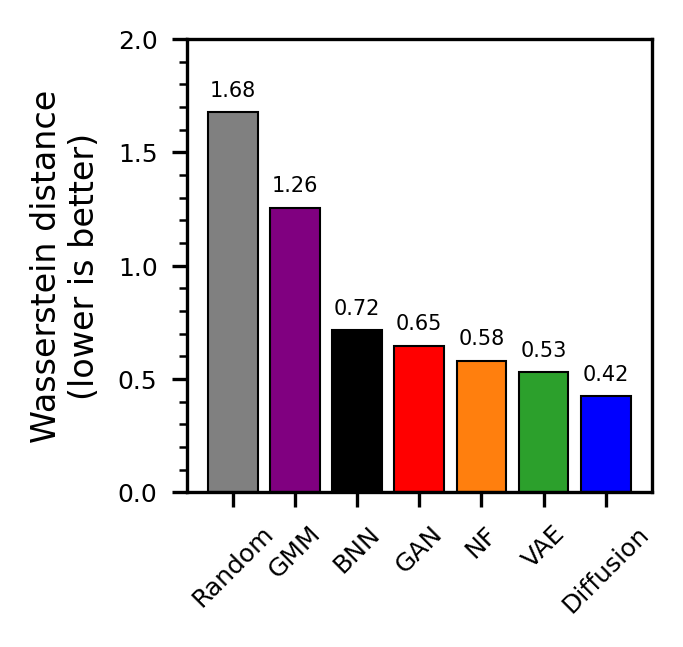

In [4]:
# Wasserstein distance
model2specs = {
    'random': {'c': 'grey', 'n': 'Random'},  
    'gmm': {'c': 'purple', 'n': 'GMM'}, 
    'bnn': {'c': 'black', 'n': 'BNN'},
    'gan': {'c': 'red', 'n': 'GAN'},
    'nf': {'c': 'tab:orange', 'n': 'NF'},
    'cvae': {'c': 'tab:green', 'n':'VAE'},
    'diff': {'c': 'blue', 'n': 'Diffusion'}
}
categories = [m['n'] for m in model2specs.values()]
values = [prec_results[x]['wsd'] for x in model2specs.keys()]

plt.figure(figsize=(2, 2), dpi=300)
plt.bar(categories, values, color=[m['c'] for m in model2specs.values()], linewidth=0.5, edgecolor='black')

for i in range(len(values)):
    plt.text(i, values[i]+0.07, round(values[i],2), ha = 'center', fontsize=5)

plt.ylabel('Wasserstein distance\n(lower is better)', fontsize=8)
plt.xticks(rotation=45, fontsize=6)  
plt.yticks(fontsize=6)
plt.minorticks_on()
ax = plt.gca()
ax.xaxis.set_tick_params(which='minor', bottom=False)
plt.ylim(0., 2.0)
# plt.savefig('figs/wsd.pdf', bbox_inches='tight')
plt.show()

[]

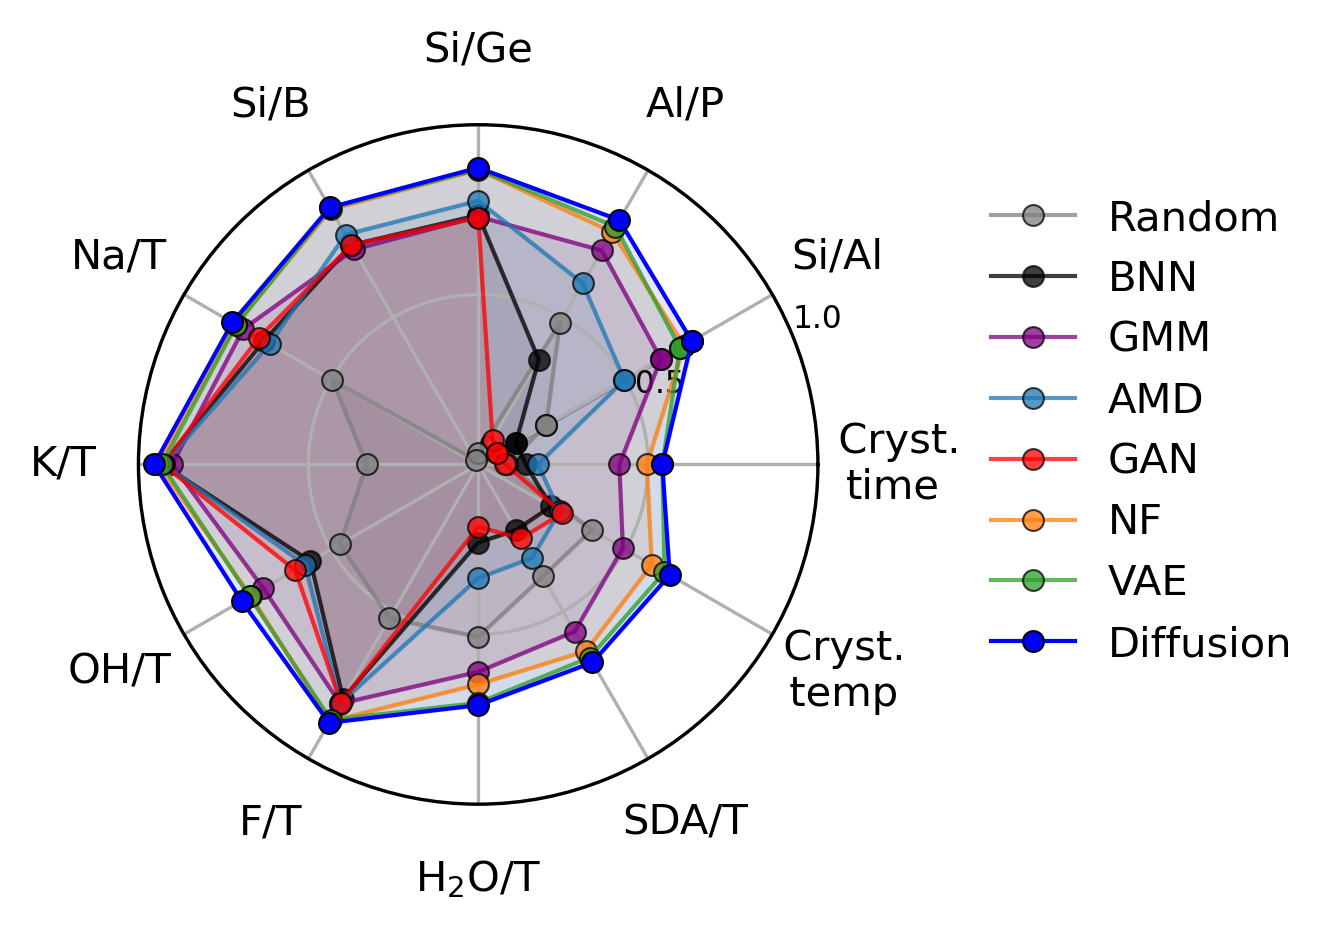

In [5]:
# Coverage
metric = 'f1' # 'f1', 'prec', 'rec'

# Creating a new figure and setting up the resolution
fig = plt.figure(figsize=(3,3),dpi=300)

model2specs = {
    'random': {'c': 'grey', 'n': 'Random'},  
    # 'nn': {'c': 'tab:brown', 'n': 'NN'}, 
    'bnn': {'c': 'black', 'n': 'BNN'},
    'gmm': {'c': 'purple', 'n': 'GMM'}, 
    'amd': {'c': 'tab:blue', 'n': 'AMD'},
    'gan': {'c': 'red', 'n': 'GAN'},
    'nf': {'c': 'tab:orange', 'n': 'NF'},
    'cvae': {'c': 'tab:green', 'n':'VAE'},
    'diff': {'c': 'blue', 'n': 'Diffusion'}
}
ax = fig.add_subplot(projection='polar')

for model_type in model2specs.keys():
    
    r=prec_results[model_type][metric]
    # r=prec_results[model_type][metric]/prec_results['diff'][metric] # normed by diff
    theta = np.deg2rad(np.linspace(30,360,12))
    
    if type(r) == pd.Series:
        r = pd.DataFrame(r)

    r_ = pd.concat([r, r.iloc[0]])
    theta_ = theta.tolist()+[theta.tolist()[0]]

    # plotting the polar coordinates on the system
    if model_type == 'diff':
        alpha = 1.
        linewidth = 1.
    else: 
        alpha = 0.75
        linewidth = 1
    plt.polar(theta_, r_ ,marker='o', markersize=5, linewidth=linewidth, color=model2specs[model_type]['c'], markeredgecolor='black', markeredgewidth=0.5, label=model2specs[model_type]['n'], alpha=alpha)
    if model_type == 'diff':
        plt.fill_between(theta_, [0.]*len(theta_), r_.values.squeeze(), color=model2specs[model_type]['c'], alpha=0.1)
    else:
        plt.fill_between(theta_, [0.]*len(theta_), r_.values.squeeze(), color=model2specs[model_type]['c'], alpha=0.1)

ax.set_xticklabels([])
ax.set_xticks(ticks=theta, labels=['Si/Al', 'Al/P', 'Si/Ge', 'Si/B', 'Na/T', 'K/T', 'OH/T', 'F/T', 'H$_2$O/T', 'SDA/T', ' Cryst.\n temp', ' Cryst.\ntime'])
ax.tick_params(pad=7.5) 

ax.set_yticklabels([])
ax.set_yticks(ticks=[0., 0.5, 1.0], labels=[0, 0.5, 1.0],fontsize=7.5)

ax.set_ylim(0., 1.)
plt.legend(loc="lower left", bbox_to_anchor=(1.2, 0.15))
# plt.savefig(f'figs/{metric}.pdf', bbox_inches='tight')
plt.plot()

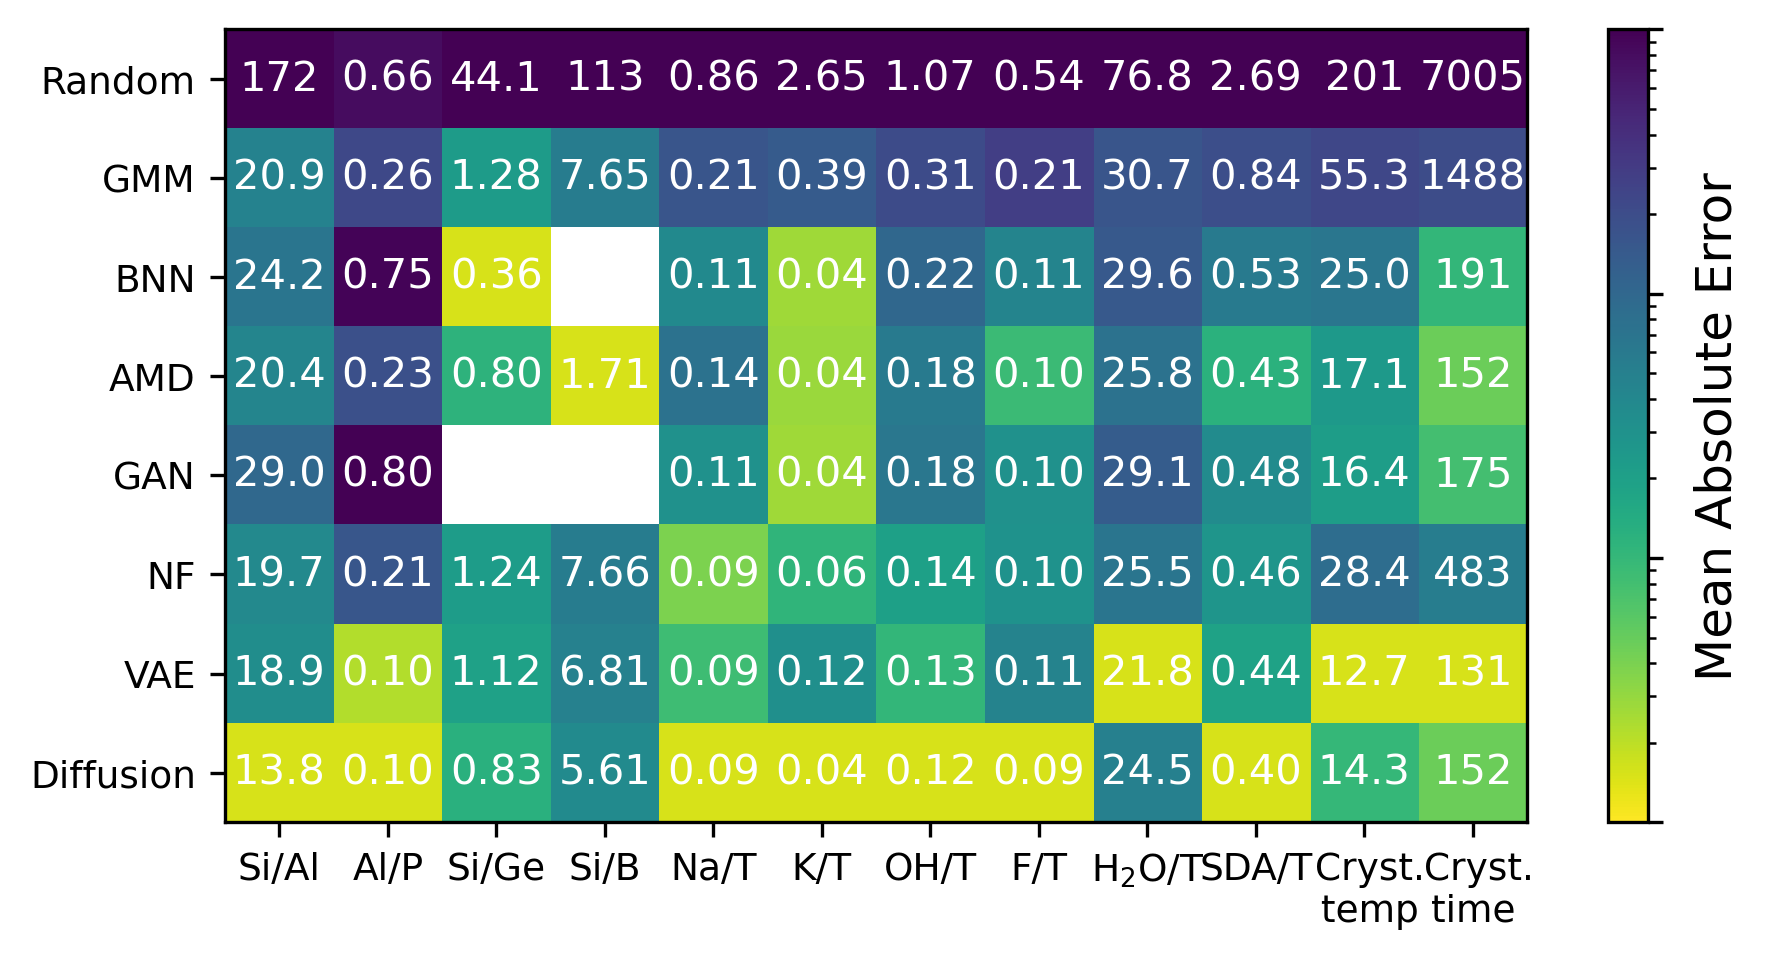

In [6]:
# Regression metrics

def format_three_digits(value):
    """ Format the value to have a total of three digits. """
    if value >= 100:
        return f"{value:.0f}"  # No decimal places for numbers 100 and above
    elif value >= 10:
        return f"{value:.1f}"  # One decimal place for numbers between 10 and 100
    else:
        return f"{value:.2f}"  # Two decimal places for numbers less than 10

model2specs = {
    'random': {'c': 'grey', 'n': 'Random'}, 
    'gmm': {'c': 'purple', 'n': 'GMM'}, 
    'bnn': {'c': 'black', 'n': 'BNN'}, 
    # 'nn': {'c': 'tab:brown', 'n': 'NN'}, 
    'amd': {'c': 'tab:blue', 'n': 'AMD'},
    'gan': {'c': 'red', 'n': 'GAN'},
    'nf': {'c': 'tab:orange', 'n': 'NF'},
    'cvae': {'c': 'tab:green', 'n':'VAE'},
    'diff': {'c': 'blue', 'n': 'Diffusion'}
}

# Create a random 8x12 matrix
data = np.array([list(prec_results[x]['reg']['maes'].values()) for x in model2specs.keys()])
data_scaled = np.zeros_like(data)
for i in range(data.shape[1]):
    data_scaled[:,i] = (data[:,i]-min(data[:,i]))/(max(data[:,i])-min(data[:,i]))+0.0015 # min_max scaling to 0-1

# Create a heatmap using imshow
plt.figure(figsize=(7,3.5),dpi=300)
plot=plt.imshow(data_scaled, cmap='viridis_r', aspect='auto', norm=LogNorm(vmin=0.001, vmax=1))
cb = plt.colorbar()  # Add a colorbar to show the scale
cb.ax.set_ylabel('Mean Absolute Error')
cb.set_ticklabels([])

# Annotate each cell with its value
for i in range(data.shape[0]):  # Loop over rows
    for j in range(data.shape[1]):  # Loop over columns
        text =plt.text(j, i, format_three_digits(data[i, j]), ha='center', va='center', color='white')


ax=plt.gca()
ax.set_xticks(range(12), labels=['Si/Al', 'Al/P', 'Si/Ge', 'Si/B', 'Na/T', 'K/T', 'OH/T', 'F/T', 'H$_2$O/T', 'SDA/T', ' Cryst.\n temp', ' Cryst.\ntime'])
ax.set_yticks(range(len(model2specs)), labels=[m['n'] for m in model2specs.values()])
plt.xticks(fontsize=9) 
plt.yticks(fontsize=9)
# plt.savefig(f'figs/reg.pdf', bbox_inches='tight')
plt.show()